# **Load the dataset: en (English)**

In [ ]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load train and test datasets
train_df = pd.read_csv("train.tsv",  sep='\t', on_bad_lines='skip')
test_df = pd.read_csv("test.tsv",  sep='\t', on_bad_lines='skip')
print('Train dataset size:', train_df.shape)
print('Test dataset size:', test_df.shape)

Train dataset size: (33845, 6)
Test dataset size: (21832, 6)


In [ ]:
# Show the first rows
train_df.head()

,id,prompt,text,label,model,domain
0,12322,you need to stop the,you need to stop the engine and wait until it ...,generated,B,tweets
1,1682,Article 11. On the basis of the information co...,The Commission shall publish the report; an in...,generated,C,legal
2,22592,I have not been tweeting,"I have not been tweeting a lot lately, but I d...",generated,D,tweets
3,17390,NO-PROMPT,I pass my exam and really thankgod for that bu...,human,NO-MODEL,tweets
4,30453,NO-PROMPT,The template will have 3 parts: a mustache sha...,human,NO-MODEL,wiki


In [ ]:
# Since we will only focus on a binary classification, we do not need the id, prompt and model variables
# We will mantain the domain variable to later study how well the model works depending on the domain
train_df = train_df.drop(['id', 'prompt', 'model'], axis=1)
test_df = test_df.drop(['id', 'prompt', 'model'], axis=1)

In [ ]:
train_df.head()

,text,label,domain
0,you need to stop the engine and wait until it ...,generated,tweets
1,The Commission shall publish the report; an in...,generated,legal
2,"I have not been tweeting a lot lately, but I d...",generated,tweets
3,I pass my exam and really thankgod for that bu...,human,tweets
4,The template will have 3 parts: a mustache sha...,human,wiki


## Split the data
We will first split the train and test dataset into X_train, y_train, domains_train and X_test, y_test, domains_test, respectivately.

In [ ]:
# Texts
X_train = train_df['text']
X_test = test_df['text']

# Extract labels
y_train = train_df['label']
y_test = test_df['label']

# Extract domain column, we will use it later
domains_train = train_df['domain']
domains_test = test_df['domain']

# **VISUALIZATION**

## Dataset Size

In [ ]:
print('Training dataset size:', len(X_train))
print('Test dataset size:', len(X_test))

Training dataset size: 33845
Test dataset size: 21832


## Class/Label distribution

In [ ]:
counts_train = y_train.value_counts().to_dict()
print("Train distribution:", counts_train)
counts_test = y_test.value_counts().to_dict()
print("Test distribution:", counts_test)

labels = counts_train.keys()
print(labels)

Train distribution: {'human': 17046, 'generated': 16799}
Test distribution: {'generated': 11190, 'human': 10642}
dict_keys(['human', 'generated'])


We notice that for both datasets, both classes *human* and *generated*, are equally distributed, i.e, the number of instances for each class is almost the same.

Let's plot it for better understanding.



Text(0, 0.5, 'Ner of Instances')

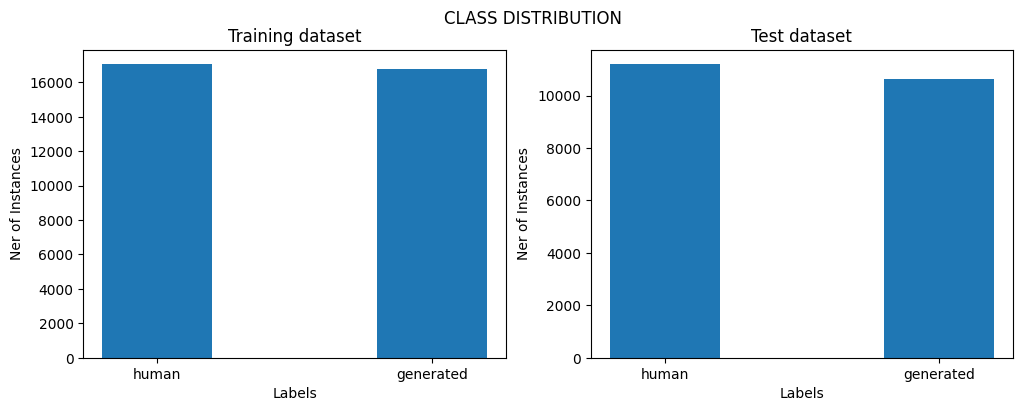

In [ ]:
import matplotlib.pyplot as plt

fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('CLASS DISTRIBUTION')

ax_train.bar(labels, counts_train.values(), width=0.4)
ax_train.set_title('Training dataset')
ax_train.set_xlabel('Labels')
ax_train.set_ylabel('Ner of Instances')

ax_test.bar(labels, counts_test.values(), width=0.4)
ax_test.set_title('Test dataset')
ax_test.set_xlabel('Labels')
ax_test.set_ylabel('Ner of Instances')

## Domain Distribution

In [ ]:
counts_doms_train = domains_train.value_counts().to_dict()
print("Domain Train distribution:", counts_doms_train)
counts_doms_test = domains_test.value_counts().to_dict()
print("Domain Test distribution:", counts_doms_test)

train_domain_labels = counts_doms_train.keys()
print(train_domain_labels)
test_domain_labels = counts_doms_test.keys()
print(test_domain_labels)

Domain Train distribution: {'wiki': 11780, 'tweets': 11697, 'legal': 10368}
Domain Test distribution: {'news': 10928, 'reviews': 10904}
dict_keys(['wiki', 'tweets', 'legal'])
dict_keys(['news', 'reviews'])


We observe that the training dataset is composed by texts from 3 domains: *wiki*, *tweets* and *legal*.

While the test dataset from 2 other different domains: *news* and *reviews*.

As well as with the class distribution, we see that the domain distribution is well balanced for both datasets.

Let's plot it for better understanding.

Text(0, 0.5, 'Ner of Instances')

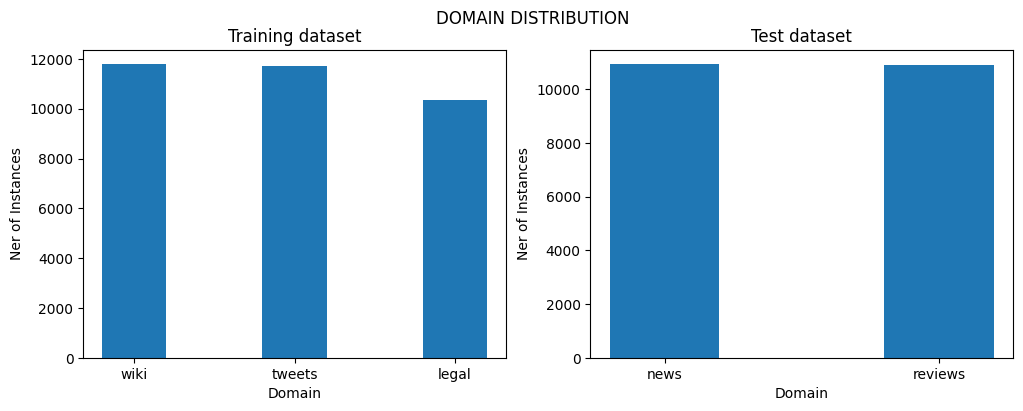

In [ ]:
fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('DOMAIN DISTRIBUTION')

ax_train.bar(train_domain_labels, counts_doms_train.values(), width=0.4)
ax_train.set_title('Training dataset')
ax_train.set_xlabel('Domain')
ax_train.set_ylabel('Ner of Instances')

ax_test.bar(test_domain_labels, counts_doms_test.values(), width=0.4)
ax_test.set_title('Test dataset')
ax_test.set_xlabel('Domain')
ax_test.set_ylabel('Ner of Instances')

Let's plot the number of instances for each class label *human* and *generated*, for each domain.

Text(0, 0.5, 'Ner of Instances')

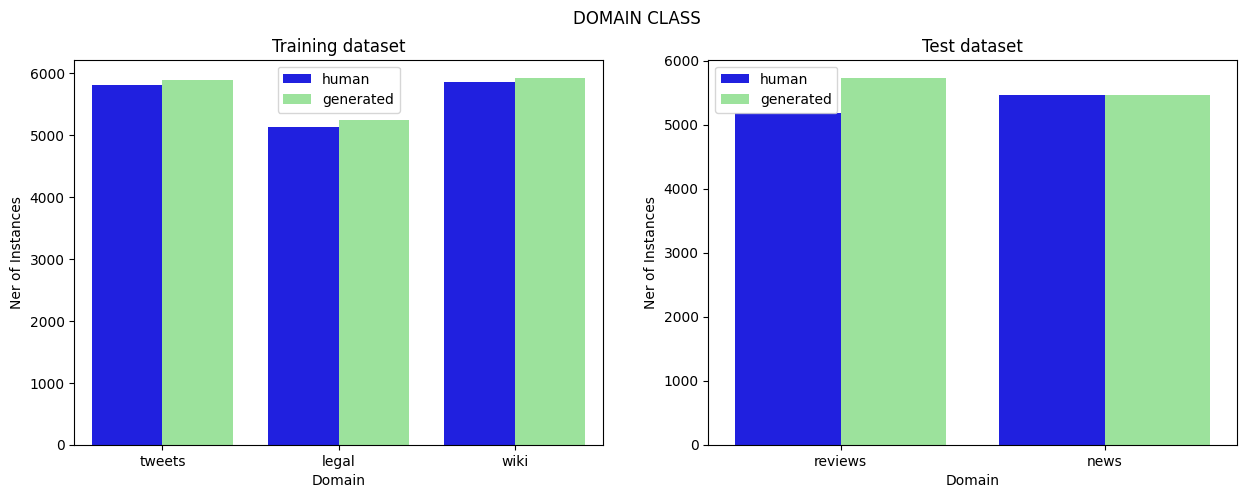

In [ ]:
import seaborn as sns

fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('DOMAIN CLASS')

sns.countplot(x=domains_train, hue=y_train, ax=ax_train, palette=['blue', 'lightgreen'])
ax_train.legend(labels)
ax_train.set_title('Training dataset')
ax_train.set_xlabel('Domain')
ax_train.set_ylabel('Ner of Instances')

sns.countplot(x=domains_test, hue=y_test, ax=ax_test, palette=['blue', 'lightgreen'])
ax_test.legend(labels)
ax_test.set_title('Test dataset')
ax_test.set_xlabel('Domain')
ax_test.set_ylabel('Ner of Instances')

We can see that the classes are well-balanced for all domains in both training and test datasets. (***Table 3 Overview***)

## Text Size Distribution

We will study the length of the texts, i.e, the number tokens each text is composed of.

In [ ]:
# Calculate the length
length_train = X_train.apply(lambda text: len(text.split()))
length_train.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    33845.00000
mean        53.65992
std         28.66047
min          1.00000
25%         22.00000
50%         62.00000
75%         81.00000
90%         87.00000
95%         89.00000
99%         92.00000
max         98.00000
Name: text, dtype: float64

The mean length of a text in the training dataset is 53.66 tokens, and the maximum length is 98 tokens.

Moreover, 50% of the texts have less than 62 tokens, while 75% have less than 81 tokens, and 99% less than 92 tokens.

As we can see from these values, the length difference is not big.

In [ ]:
# Calculate the length
length_test = X_test.apply(lambda text: len(text.split()))
length_test.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    21832.000000
mean        62.629306
std         20.796394
min          1.000000
25%         52.000000
50%         69.000000
75%         77.000000
90%         84.000000
95%         86.000000
99%         91.000000
max         98.000000
Name: text, dtype: float64

The mean length of a text in the test dataset is 62.63 tokens, and the maximum length is 98 tokens.

In addition, 50% of the texts have less than 69 tokens, while 75% have less than 77 tokens, and 99% less than 91 tokens.

Overall for both datasets, the length difference of tokens in the texts is not big.

Let's visualize it.

Text(0, 0.5, 'Frequency')

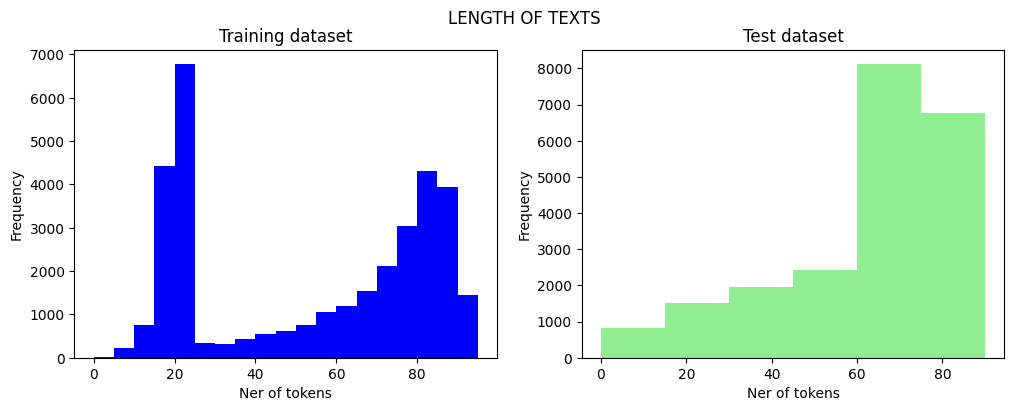

In [ ]:
import numpy as np

fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('LENGTH OF TEXTS')

ax_train.hist(length_train, bins=np.arange(0, 100, 5), color='blue')
ax_train.set_title('Training dataset')
ax_train.set_xlabel('Ner of tokens')
ax_train.set_ylabel('Frequency')

ax_test.hist(length_test, bins=np.arange(0, 100, 15), color='lightgreen')
ax_test.set_title('Test dataset')
ax_test.set_xlabel('Ner of tokens')
ax_test.set_ylabel('Frequency')

From the training dataset plot, we can tell that there is a high number of texts that are formed by approximately 20 tokens, which we could not interpret from only the description above. This could be due to the training dataset containing text from the domain *tweets*, which tend to be short.

From the test dataset plot, we can see there are many texts containing between 60 and 80 tokens.

### Text Size Distribution for each Domain

Let's see the text length for each of the existing domains.

In [ ]:
# Create a new dataset joining texts, ner of tokens, and domain
train_dataset = [[X_train[i], length_train[i], domains_train[i]] for i in range(len(X_train))]
train_dataset = pd.DataFrame(train_dataset, columns=['Text', 'Length', 'Domain'])

test_dataset = [[X_test[i], length_test[i], domains_test[i]] for i in range(len(X_test))]
test_dataset = pd.DataFrame(test_dataset, columns=['Text', 'Length', 'Domain'])

Text(0, 0.5, 'Density')

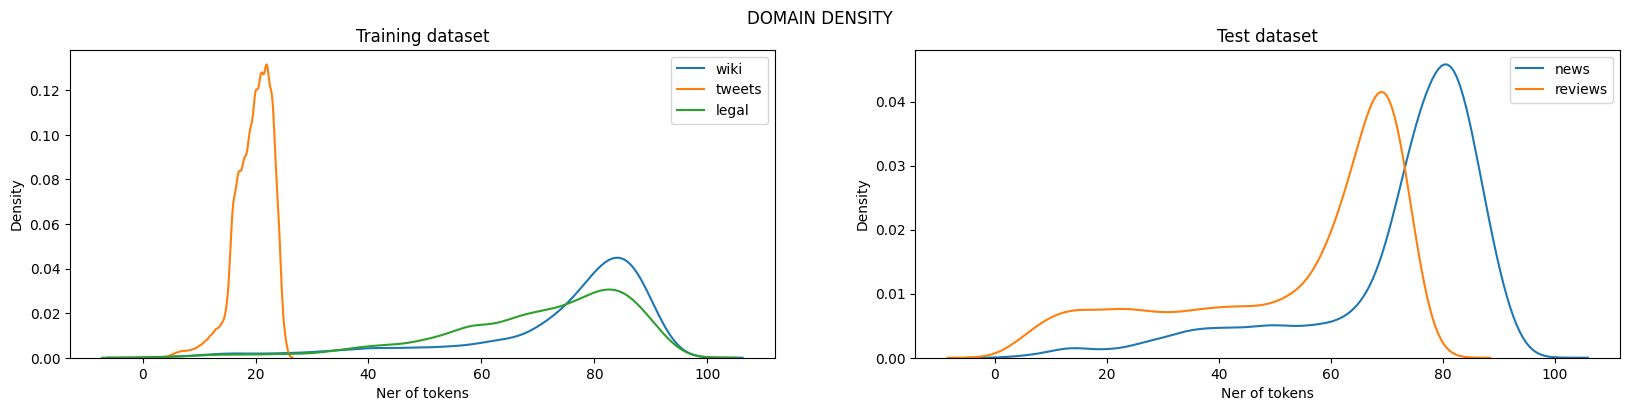

In [ ]:
# Plot the figure
fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(20, 4))
fig.suptitle('DOMAIN DENSITY')

for domain in train_domain_labels:
    data = train_dataset[train_dataset['Domain'] == domain]['Length']
    sns.kdeplot(x=data, label=domain, ax=ax_train)
ax_train.legend()
ax_train.set_title('Training dataset')
ax_train.set_xlabel('Ner of tokens')
ax_train.set_ylabel('Density')

for domain in test_domain_labels:
    data = test_dataset[test_dataset['Domain'] == domain]['Length']
    sns.kdeplot(x=data, label=domain, ax=ax_test)
ax_test.legend()
ax_test.set_title('Test dataset')
ax_test.set_xlabel('Ner of tokens')
ax_test.set_ylabel('Density')

We notice that the texts of length near to 20 tokens belong to the domain *tweets* as we initially thought.

Overview paper: ***The maximum number of completion tokens was manually selected for each domain to be similar to the median token-length of the human texts: 20 tokens for tweets, 70 for reviews, and 100 for news, legal, and how-to articles.***

#### Class density distribution

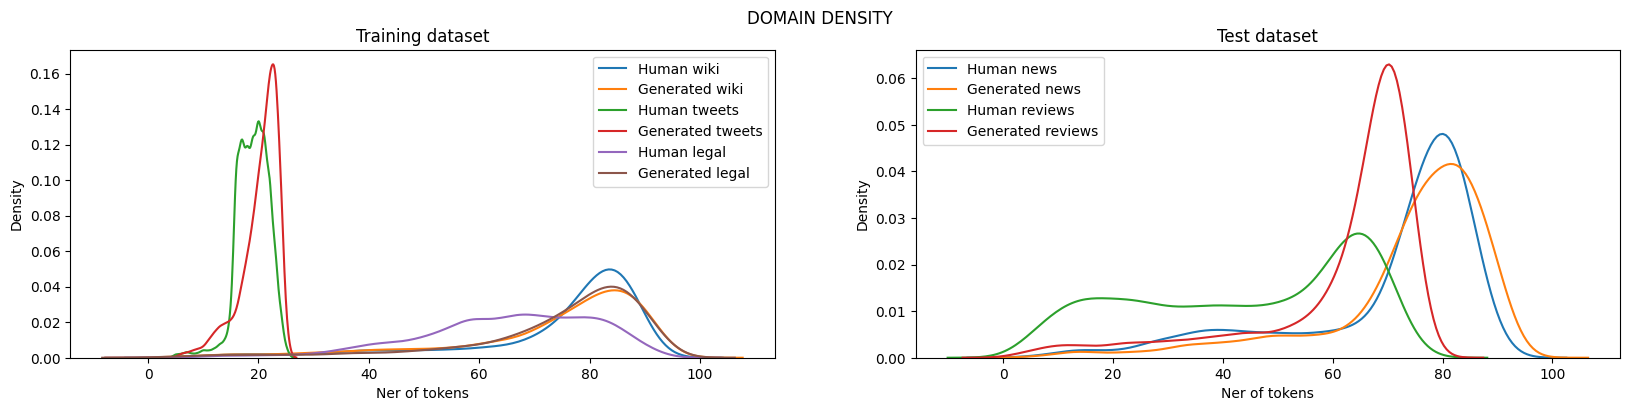

In [ ]:
# Plot figure
fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(20, 4))
fig.suptitle('DOMAIN DENSITY')

# TRAINING DATASET
# Human label
train_human_dataset = [[X_train[i], length_train[i], domains_train[i]] for i in range(len(X_train)) if y_train[i]=='human']
train_human_dataset = pd.DataFrame(train_human_dataset, columns=['Text', 'Length', 'Domain'])
# Generated label
train_generated_dataset = [[X_train[i], length_train[i], domains_train[i]] for i in range(len(X_train)) if y_train[i]=='generated']
train_generated_dataset = pd.DataFrame(train_generated_dataset, columns=['Text', 'Length', 'Domain'])

# Plot human and generated domains
for domain in train_domain_labels:
    human_data = train_human_dataset[train_human_dataset['Domain'] == domain]['Length']
    sns.kdeplot(x=human_data, label=f'Human {domain}', ax=ax_train)
    generated_data = train_generated_dataset[train_generated_dataset['Domain'] == domain]['Length']
    sns.kdeplot(x=generated_data, label=f'Generated {domain}', ax=ax_train)

ax_train.set_title('Training dataset')
ax_train.set_xlabel('Ner of tokens')
ax_train.set_ylabel('Density')
ax_train.legend()

# TESTING DATASET
# Human label
test_human_dataset = [[X_test[i], length_test[i], domains_test[i]] for i in range(len(X_test)) if y_test[i]=='human']
test_human_dataset = pd.DataFrame(test_human_dataset, columns=['Text', 'Length', 'Domain'])
# Generated label
test_generated_dataset = [[X_test[i], length_test[i], domains_test[i]] for i in range(len(X_test)) if y_test[i]=='generated']
test_generated_dataset = pd.DataFrame(test_generated_dataset, columns=['Text', 'Length', 'Domain'])

# Plot human and generated domains
for domain in test_domain_labels:
    human_data = test_human_dataset[test_human_dataset['Domain'] == domain]['Length']
    sns.kdeplot(x=human_data, label=f'Human {domain}', ax=ax_test)
    generated_data = test_generated_dataset[test_generated_dataset['Domain'] == domain]['Length']
    sns.kdeplot(x=generated_data, label=f'Generated {domain}', ax=ax_test)

ax_test.set_title('Test dataset')
ax_test.set_xlabel('Ner of tokens')
ax_test.set_ylabel('Density')
ax_test.legend()

plt.show()

We can see that for the reviews domain in the test dataset, the human texts are around 10 and 70 tokens. While the generated texts are composed by between 60 and 80 tokens.

For the rest of domains, the texts are approximately of the same length.

### Text Size Distribution for each Label

Text(0, 0.5, 'Density')

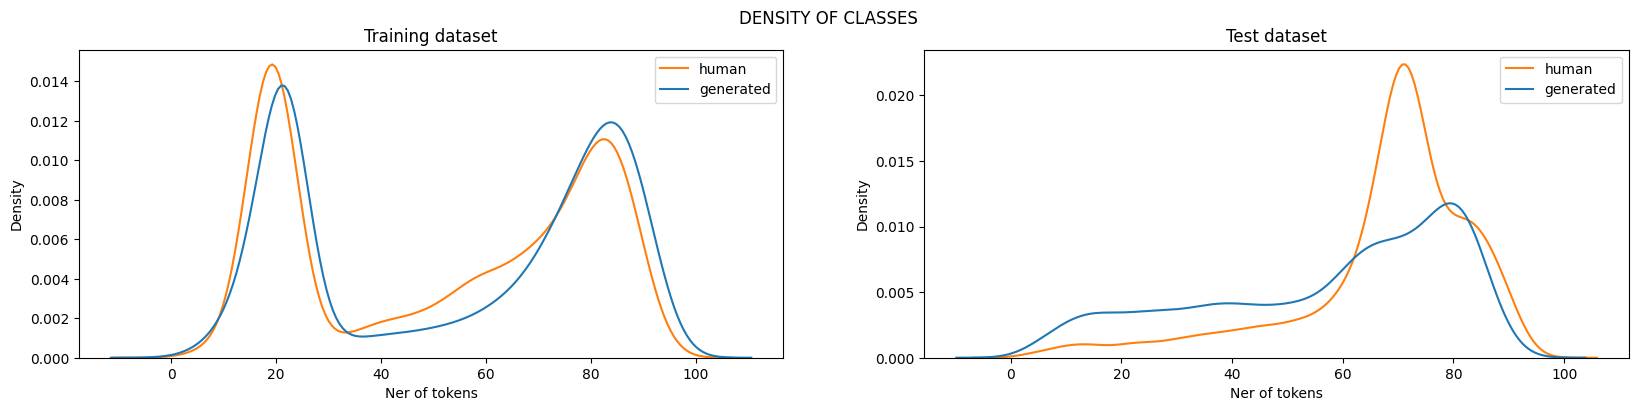

In [ ]:
fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(20, 4))
fig.suptitle('DENSITY OF CLASSES')

sns.kdeplot(x=length_train, hue=y_train, ax=ax_train)
ax_train.legend(labels)
ax_train.set_title('Training dataset')
ax_train.set_xlabel('Ner of tokens')
ax_train.set_ylabel('Density')

sns.kdeplot(x=length_test, hue=y_test, ax=ax_test)
ax_test.legend(labels)
ax_test.set_title('Test dataset')
ax_test.set_xlabel('Ner of tokens')
ax_test.set_ylabel('Density')

For the training dataset, the class distribution is well balanced for all lengths of the texts.

While in the test dataset, for the texts with lengths between 60 and 80 tokens, the number of texts written by a human is greater than the generated texts, being the peak 70 tokens. However, as we saw in the section *Class/Label Distribution*, overall the distribution of classes is well proportioned.

**BONUS Question:  In the test dataset, why do we see that there are more human texts than generated for length 60-80?**

We actually observe that the are more generated texts than human text for this length interval. Hence, our assumption from the previous plot is wrong, i.e., the number of human texts composed by 60 to 80 tokens is indeed not greater than the generated texts, in the test dataset.



In [ ]:
texts_human = [[X_test[i], length_test[i], domains_test[i]] for i in range(len(X_test)) if (length_test[i] >= 60 and length_test[i] <= 80 and y_test[i]=='human')]
texts_human = pd.DataFrame(texts_human, columns=['Text', 'Length', 'Domain'])
texts_generated = [[X_test[i], length_test[i], domains_test[i]] for i in range(len(X_test)) if (length_test[i] >= 60 and length_test[i] <= 80 and y_test[i]=='generated')]
texts_generated = pd.DataFrame(texts_generated, columns=['Text', 'Length', 'Domain'])
print('Ner of human texts: ', len(texts_human))
print('Ner of generated texts: ', len(texts_generated))

Ner of human texts:  4401
Ner of generated texts:  6784


Let's plot the domains these texts belong to.

Text(0, 0.5, 'Density')

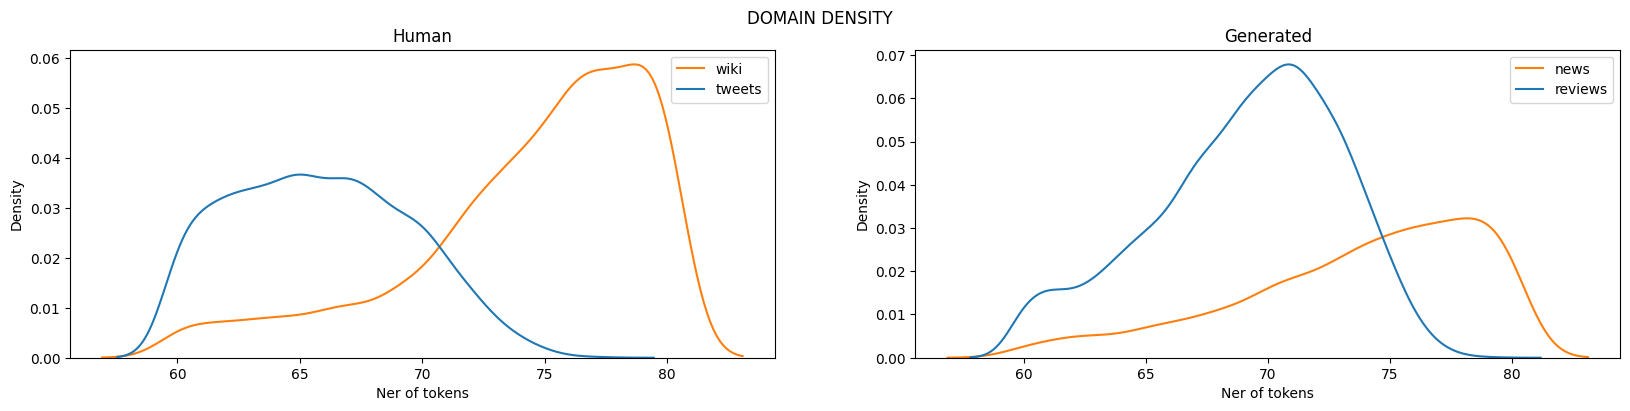

In [ ]:
fig, (ax_human, ax_generated) = plt.subplots(1, 2, figsize=(20, 4))
fig.suptitle('DOMAIN DENSITY')

sns.kdeplot(x=texts_human['Length'], hue=texts_human['Domain'], ax=ax_human)
ax_human.legend(train_domain_labels)
ax_human.set_title('Human')
ax_human.set_xlabel('Ner of tokens')
ax_human.set_ylabel('Density')

sns.kdeplot(x=texts_generated['Length'], hue=texts_generated['Domain'], ax=ax_generated)
ax_generated.legend(test_domain_labels)
ax_generated.set_title('Generated')
ax_generated.set_xlabel('Ner of tokens')
ax_generated.set_ylabel('Density')

For the peak (70 tokens), human texts belong to both domains equally, while the generated texts to the domain *reviews*.

#### Overall class/label distribution (whole dataset).
Let's see the label distribution from joining training and test datasets.

Text(0, 0.5, 'Density')

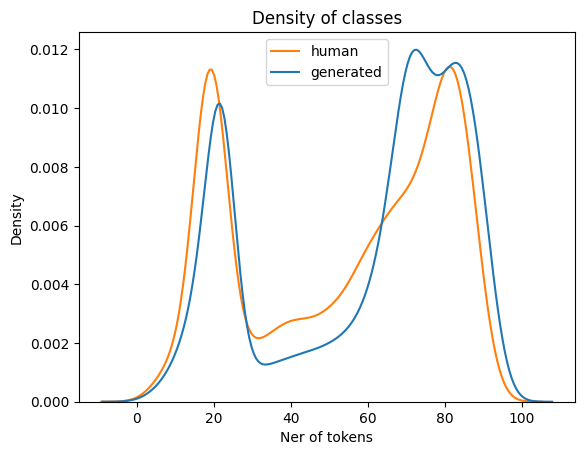

In [ ]:
df = pd.concat([train_df, test_df])
df['length'] = df['text'].apply(lambda text: len(text.split()))
sns.kdeplot(data=df, x='length', hue='label')
plt.legend(labels)
plt.title('Density of classes')
plt.xlabel('Ner of tokens')
plt.ylabel('Density')

The overall distribution is pretty balanced for both *human* and *generated* labels.